
# IceVision Inference on BBoxes

Here we demonstrate the inference capability of the bounding box detector when operating on images not in the training set, applying it to the additional 12,000 unlabeled video frames, to see what "physics" can be learned.

> Note: This section reads requires access to the full 14,000 (previously unlabeled) video frames, which are not part of our dataset release. If this is a point of contention for reviewers, temporary access to these frames will be  enabled so that these graphs can be reproduced. However for now, these data are considered "proprietary". 

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

In [ ]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
#try:
#    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
#    !chmod +x install_colab.sh && ./install_colab.sh
#except:
#    print("Ignore the error messages and just keep going")

In [ ]:
#all_slow

In [ ]:
!pip install espiownage -Uqq
from espiownage.core import *
sysinfo()

TORCH_VERSION=torch1.8.0; CUDA_VERSION=cu101
CUDA available = True, Device count = 1, Current device = 0
Device name = TITAN X (Pascal)
hostname: lecun


In [ ]:
#skip
# FOR COLAB: Install IceVision, then grab latest and force a hard restart.
#  Locally, you can & should still run (most of) the install_colab.sh script
! [ -e /content ] &&  wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
! [ -e /content ] &&  chmod +x install_colab.sh && ./install_colab.sh 
! [ -e /content ] &&  pip install git+git://github.com/airctic/icevision.git --upgrade && kill -9 -1

In [ ]:
from icevision.all import *
import pandas as pd

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/sstudent/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


The real test: if this next import doesn't pass then your IV install is old/messed up:

In [ ]:
from icevision.models.checkpoint import *

Main definitions: Where are the images, and where's the model? 

## Images

In [ ]:
imgdir = '/home/sstudent/datasets/zooniverse_steelpan'
img_files = get_image_files(imgdir)
len(img_files)

14000

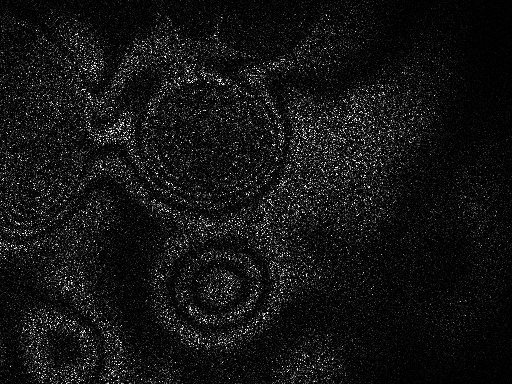

In [ ]:
img = PIL.Image.open(img_files[13500])
img

## Load Model from Checkpoint

In [ ]:
#skip
k = 0
checkpoint_path = f'espi-retinanet-checkpoint-real-k{k}.pth'

checkpoint_and_model = model_from_checkpoint(checkpoint_path, map_location='cuda',
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        img_size=384)

model = checkpoint_and_model["model"]
# Check device
model.to('cuda')
device=next(model.parameters()).device
device

Use load_from_local loader


/home/sstudent/envs/iv2/lib/python3.8/site-packages/mmcv/cnn/utils/weight_init.py:118: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  warnings.warn(


device(type='cuda', index=0)

In [ ]:
# Just logging the info
model_type = checkpoint_and_model["model_type"]
backbone = checkpoint_and_model["backbone"]
class_map = checkpoint_and_model["class_map"]
img_size = checkpoint_and_model["img_size"]
model_type, backbone, class_map, img_size

(<module 'icevision.models.mmdet.models.retinanet' from '/home/sstudent/envs/iv2/lib/python3.8/site-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 <ClassMap: {'background': 0, 'AN': 1}>,
 384)

In [ ]:
# Transforms
img_size = checkpoint_and_model["img_size"]
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

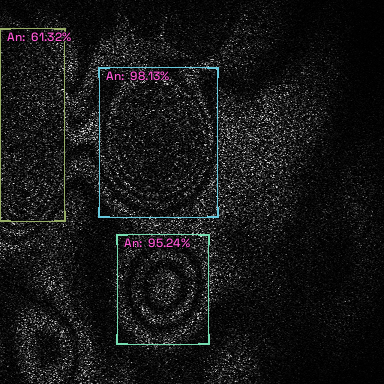

In [ ]:
# testing on single image:
img = PIL.Image.open(img_files[13500])
img = img.resize((384,384)).convert('RGB')

pred_dict  = model_type.end2end_detect(img, valid_tfms, model, class_map=class_map, detection_threshold=0.5)
pred_dict['img']

## Batch Inference

In [ ]:
# Create a dataset  - takes a while for 14,000 images!
imgs_array = [PIL.Image.open(Path(fname)).convert('RGB') for fname in img_files]

In [ ]:
infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map=class_map)

In [ ]:
# Batch Inference...here we go!
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

  0%|          | 0/3500 [00:00<?, ?it/s]

In [ ]:
len(infer_ds), len(preds)

(14000, 14000)

In [ ]:
preds[0].detection.

## Generate BBoxes and Image Crops

In [ ]:
def convert_bb(bb, square=384, width=512, height=384):
    "IceVision borked our non-square images so all the bboxes are off; Convert back"
    bb = [int(x*width/square) for x in bb]  # unshrink everything to make it like a 512x512 image
    bb[1], bb[3] = bb[1]-(width-height)//2, bb[3]-(width-height)//2   # now subtract off the coords of the "bar" at the top
    return [bb[0],bb[1],bb[2],bb[3]]

def get_bblist(pred):
    "given IV pred, return list of bboxes"
    my_bblist = []
    bblist = pred.pred.detection.bboxes
    for i in range(len(bblist)):
        bb = [bblist[i].xmin, bblist[i].ymin, bblist[i].xmax, bblist[i].ymax]
        bb = convert_bb(bb)
        my_bblist.append([bb])
    return my_bblist

def gen_crops(meta_file, img, bblist, crops_dir='crops_iv', verbose=False):
    if verbose: print("gen_crops: bblist = ", bblist)
    for bb_ in bblist:
        if verbose: print("    gen_crops: bb_ = ", bb_)
        if bb_ is not None:
            bb = bb_[0]   # comes wrapped in an extra list
            if verbose: print("     gen_crops: bb = ", bb)
            #print("meta_file, bb=",meta_file, bb)
            img_cropped = crop_to_bbox(img, bb)
            if img_cropped is not None:
                out_file = crops_dir+'/'+str(Path(meta_file).stem)+f"_{bb[0]}_{bb[1]}_{bb[2]}_{bb[3]}.png"
                img_cropped.save(out_file)

In [ ]:
from PIL import ImageDraw

def draw_bbs_on_img(img, bblist, color="cyan", verbose=False):
    "Draws a rectangle on image. IN PLACE"
    if [] == bblist: return 
    draw = ImageDraw.Draw(img)
    for bb_ in bblist:
        if verbose: print(" draw_bb_on_img: bb_ = ",bb_)
        if bb_ is not None:
            bb = bb_[0]
            if verbose: print(" draw_bb_on_img: bb = ",bb)
            draw.rectangle(((bb[0], bb[1]), (bb[2],bb[3])), outline=color)
        

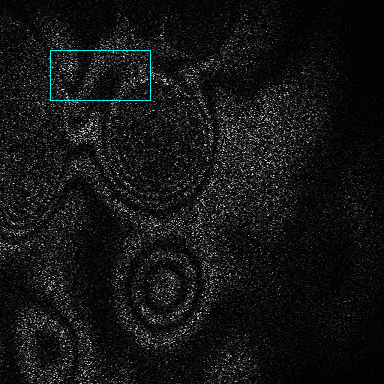

In [ ]:
im = img.copy()
draw_bb_on_img(im, (50,50,150,100))
im

Loop through all the images generating bbox lists and crops

In [ ]:
results = []  # list to become dataframe
crops_dir = 'crops_iv'
mkdir_if_needed(crops_dir)

for i in range(0,len(preds)):
    meta_filename = str(Path(img_files[i]).stem)+'.csv'
    bblist = get_bblist(preds[i])
    if [] != bblist: 
        gen_crops(meta_filename, imgs_array[i], bblist, crops_dir, verbose=verbose)
        #draw_bbs_on_img(imgs_array[i], bblist, verbose=verbose)  # draws in place # do this after crops
    line_list = [meta_filename, bblist, i]
    results.append(line_list)
print(f"\n{len(results)} images processed.")


14000 images processed.


In [ ]:
# store as pandas dataframe
pd.set_option('display.max_rows', None)
res_df = pd.DataFrame(results, columns=['filename', 'bblist','i'])
res_df.iloc[13400:13600] # take a look.  Note that Pandas saves lists as strings!

,filename,bblist,i
13400,06241902_proc_01400.csv,"[[[143, 99, 264, 208]], [[0, 30, 85, 221]]]",13400
13401,06241902_proc_01401.csv,"[[[139, 81, 275, 214]], [[0, 54, 84, 228]]]",13401
13402,06241902_proc_01402.csv,"[[[138, 83, 277, 218]], [[0, 41, 85, 241]], [[198, 246, 286, 333]]]",13402
13403,06241902_proc_01403.csv,"[[[136, 77, 282, 218]], [[183, 238, 283, 342]], [[1, 40, 83, 245]]]",13403
13404,06241902_proc_01404.csv,"[[[128, 82, 271, 216]], [[173, 238, 278, 341]], [[0, 47, 85, 226]]]",13404
13405,06241902_proc_01405.csv,"[[[126, 74, 280, 219]], [[171, 245, 274, 342]], [[1, 36, 87, 251]]]",13405
13406,06241902_proc_01406.csv,"[[[128, 70, 287, 216]], [[164, 247, 267, 349]], [[0, 47, 81, 232]]]",13406
13407,06241902_proc_01407.csv,"[[[130, 72, 283, 217]], [[167, 249, 264, 347]], [[0, 51, 82, 233]]]",13407
13408,06241902_proc_01408.csv,"[[[125, 73, 282, 220]], [[1, 42, 76, 228]], [[169, 256, 259, 347]]]",13408
13409,06241902_proc_01409.csv,"[[[130, 75, 282, 218]], [[0, 39, 80, 238]]]",13409


In [ ]:
res_df.to_csv('bboxes_all_frames.csv', index=False)

### Draw bounding boxes

In [ ]:
results = []  # list to become dataframe
for i in range(0,len(preds)):
    meta_filename = str(Path(img_files[i]).stem)+'.csv'
    bblist = get_bblist(preds[i])
    if [] != bblist: 
        draw_bbs_on_img(imgs_array[i], bblist, verbose=verbose)  # draws in place # do this after crops
    line_list = [meta_filename, bblist, i]
print(f"\n{len(results)} images processed.")

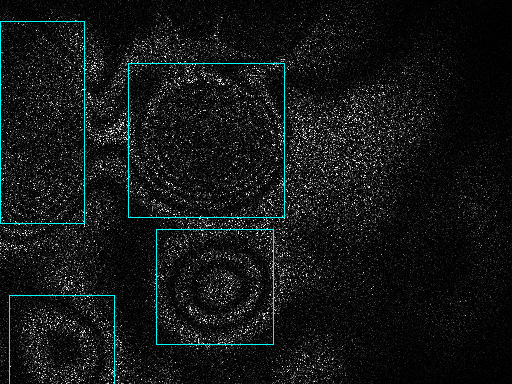

In [ ]:
imgs_array[13500]

### Now save the bbox-drawn images to files

In [ ]:
boxdir = 'box_drawings_iv'
mkdir_if_needed(boxdir)
for i in range(len(imgs_array)):
    fname = img_files[i]
    outname = boxdir+'/'+str(Path(fname).stem)+'_B.png'
    if i%500 == 0: print(f"{i}: saving {outname}")
    imgs_array[i].save (outname)

0: saving box_drawings_iv/06240907_proc_00000_B.png
500: saving box_drawings_iv/06240907_proc_00500_B.png
1000: saving box_drawings_iv/06240907_proc_01000_B.png
1500: saving box_drawings_iv/06240907_proc_01500_B.png
2000: saving box_drawings_iv/06240909_proc_00000_B.png
2500: saving box_drawings_iv/06240909_proc_00500_B.png
3000: saving box_drawings_iv/06240909_proc_01000_B.png
3500: saving box_drawings_iv/06240909_proc_01500_B.png
4000: saving box_drawings_iv/06240910_proc_00000_B.png
4500: saving box_drawings_iv/06240910_proc_00500_B.png
5000: saving box_drawings_iv/06240910_proc_01000_B.png
5500: saving box_drawings_iv/06240910_proc_01500_B.png
6000: saving box_drawings_iv/06240912_proc_00000_B.png
6500: saving box_drawings_iv/06240912_proc_00500_B.png
7000: saving box_drawings_iv/06240912_proc_01000_B.png
7500: saving box_drawings_iv/06240912_proc_01500_B.png
8000: saving box_drawings_iv/06240913_proc_00000_B.png
8500: saving box_drawings_iv/06240913_proc_00500_B.png
9000: saving b

### Make a movie of the bounding boxes

In [ ]:
# Do this from a shell; not enough memory to run inside Jupyter:
# cd box_drawings_iv; ffmpeg -loglevel quiet -r 30 -pattern_type glob -i '*.png' -c:v libx264 bboxes.mp4

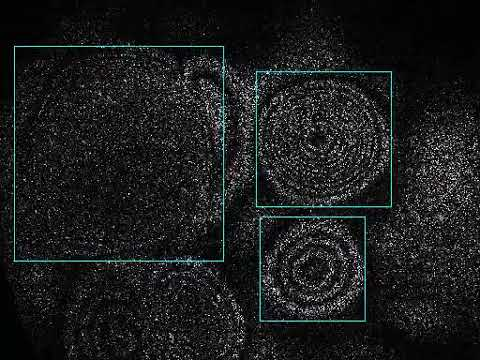

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('-5cDhgbomH0')